In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    r2_score
)

from tqdm.notebook import tqdm

from mlght.core.training import Trainer
from mlght.core.scalers import ResettableStandardScaler
from mlght.utils.postprocessing import ParametersDenormalization

# Example 1: Linear Model Interpretation

## Introduction
One crucial aspect is model interpretability. Linear models are interpretable due to their formulation. The response variable $\mathbf{y}$ is related to the input descriptors $\left\{\mathbf{x}_i ; \; i = 1, \dots, p \right\}$ by the linear relationship

$\mathbf{y} = \displaystyle \sum_{i = 1}^{p} \beta_i \, \mathbf{x}_i$

Once the model is fit, the parameter $\beta_i$ tell us how much each descriptor $\mathbf{x}_i$ impacts on the response $\mathbf{y}$.

Often, input data should be normalized. That is, data are transformed in order for all the descriptors to be expressed in the same values range. This makes the model more stable. For example, the standard scaling method centers data around the mean and scales the result by the standard deviation, for each descriptor. In formulae

$\displaystyle \tilde{\mathbf{x}}_i = \frac{\mathbf{x}_i - \mu_{i}}{\sigma_i}$

Then, the model is fit on the scaled data. 

Once the model is fit on scaled data, its parameters tell us the importance of each **scaled** descriptor. It is necessary to unscale the model parameters in order to express these quantities in the **original unscaled space**. Otherwise, they inform us about the descriptors importances only in a relative sense. That is, how much the response is impacted by the descriptors *in the sense of the response and inputs standard deviations*. 

## Example
In the following example, we define a vector of coefficients $\left\{ \beta_i; \; i  = 1, \dots, p \right\}$. We simulate a synthetic dataset $\mathbf{X}$ and we compute the response simply by 

$\mathbf{y} = \beta_0 + \boldsymbol{\beta}^T \, X$

where $\beta_0$ is the intercept.

Let us use the `mlght` framework to fit a simple linear model and to show how to retrieve the unscaled parameters.

### Dataset and ground-truth coefficients

In [2]:
# Define the coefficients
intercept = 2
coeffs = np.array([
    0.5,
    2,
    0.5,
    0.0001,
    -1.08,
    0.005,
    -0.1,
    1.5,
    2.5,
    3,
    0.01,
    3.66,
    -4.06,
    -2,
    0.5,
    0.1
])

# Define the dataset X, its columns names and the label
sample = np.random.uniform(0, 10, size = (1000, len(coeffs)))
dvariables = [f"X_{i}" for i in range(1, len(coeffs)+1)]
label = ["Target"]

# Make a pandas.DataFrame of X and y
data = pd.DataFrame(sample[:1000], columns = dvariables)
target = pd.DataFrame(data = intercept + coeffs @ data.T, columns = label)

### Trainer instantiation
We use the `mlght.core.scalers.ResettableStandardScaler` to normalize input data.

In [3]:
# Instantiate the trainer, use the Resettable Standard Scaler
trainer = Trainer(
    base_estimator = Ridge,
    estimator_name = "RidgeRegression",
    estimator_kwargs = dict(
        alpha = 0.5,
        fit_intercept = True
    ),
    n_cv_splits = 5,
    n_estimators = 10,
    eval_metrics = {"MAE": mean_absolute_error},
    input_normalizer = ResettableStandardScaler,
    target_normalizer = ResettableStandardScaler,
    pbar_module = tqdm
)

### K-fold cross validation

In [4]:
trainer.run_kfold_cv(data, target)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

+----------+-----------------+
| Metric   | Target          |
+==========+=================+
| MAE      | 0.1388 ± 0.1146 |
+----------+-----------------+


### Model training
Note: as for this proof-of-concept case, let us use the full dataset, with no need to split in train and test partitions.

In [5]:
trainer.fit(data, target)

  0%|          | 0/10 [00:00<?, ?it/s]

### Parameters denormalization
Data have been scaled according to the expression

$\displaystyle \tilde{\mathbf{x}}_i = \frac{\mathbf{x}_i - \mu_{i}}{\sigma_i}$

so the trained model is expressed in terms of scaled data space. That is

$\displaystyle \tilde{\mathbf{y}} = \tilde{\beta}_0 + \sum_{i = 1}^{p} \tilde{\beta}_i \, \tilde{\mathbf{x}}_i$

To interpret the model, we may want to assess the absolute importances of the parameters. To do so, we plug the definition of $\tilde{\mathbf{x}}_i$ in this last expression. Some computations give

$\displaystyle \mathbf{y} = \underbrace{
                    S(\mathbf{y}) \left( \tilde{\beta}_0 - \sum_{j = 1}^{p}
                         \frac{C(\mathbf{x}_j)}{S(\mathbf{x}_j)}
                         \mathbf{x}_j \right) + C(\mathbf{y})
}_{\beta_0} + \sum_{j = 1}^{p} \underbrace{
    \left( \tilde{\beta}_j \frac{S(\mathbf{y})}{S(\mathbf{x}_j)} \right)
}_{\beta_i} \mathbf{x}_j$

The method `mlght.utils.postprocessing.ParametersDenormalization.parameters_denormalization` performs exactly this inversion, giving the unscaled parameters $\beta_i$.

In [6]:
params = ParametersDenormalization.parameters_denormalization(
    trainer
        .get_models(ensemble = False)
        .get_model_params(asarray = True),
    trainer.xscaler,
    trainer.yscaler,
    fit_intercept = True
)

coeffs_fit = np.mean(params[0], axis = 0)
intercept_fit = np.mean(params[1], axis = 0)

### Unscaled parameters visualization
Note: $X_0$ is the intercept.

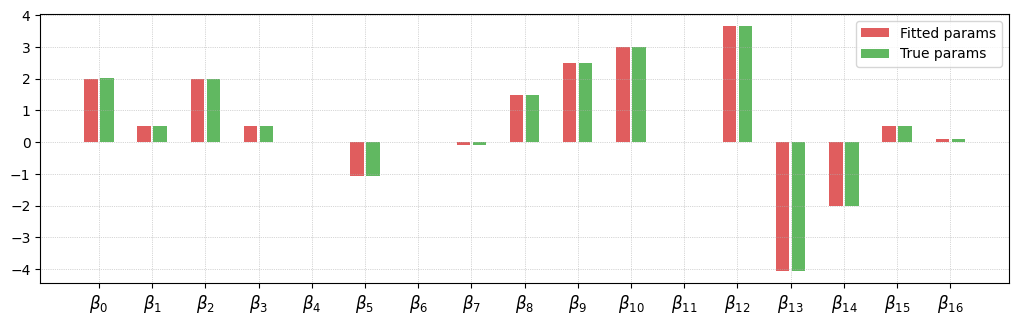

In [7]:
coeffs_ = np.concatenate((np.array([intercept]), coeffs), axis = 0)
params_ = np.concatenate((np.array([intercept_fit]), coeffs_fit), axis = 0)

fig, ax = plt.subplots(figsize = (12.5, 3.5))
ax.bar(
    np.arange(len(coeffs_)) - 0.15,
    coeffs_,
    0.25,
    facecolor = "tab:red",
    label = "Fitted params",
    alpha = 0.75
)
ax.bar(
    np.arange(len(coeffs_)) + 0.15,
    params_,
    0.25,
    facecolor = "tab:green",
    label = "True params",
    alpha = 0.75
)

ax.set_xticks(np.arange(len(coeffs_)))
ax.set_xticklabels([r"$\beta_0$"] + [rf"$\beta_{{{i+1}}}$" for i in range(len(data.columns))],
                   rotation = 0,
                   fontsize = 12)
ax.legend()
ax.grid(lw = 0.5, ls = ":")
plt.show()

# Example 2: A Regression Task
## Introduction
The following code cells show the use of the `Trainer` class, on a more realistic case.

In [30]:
# Prepare the skeleton of a possible data science project
class DataPreparation:
    @staticmethod
    def prepare_data(path):
        data = pd.read_csv(path)
        # --- Feature Engineering & Cleaning ---
        data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)
        
        # CRITICAL STEP: Convert integers to categorical type
        categorical_features = ['season', 'yr', 'mnth', 'hr', 'weekday', 'weathersit']
        for col in categorical_features:
            data[col] = data[col].astype('category')
        
        # One-Hot Encode the categorical variables
        data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)
        
        X = data_encoded.drop('cnt', axis=1)
        y = data_encoded[['cnt']]

        return X, y

class EvaluationFramework:
    @staticmethod
    def plot_groundtruth_predictions(ytrue, ypred):
        fig, ax = plt.subplots(figsize = (7.5, 4.5))
        ax.scatter(
            ytrue.values,
            ypred.values,
            c = "tab:blue",
            alpha = 0.75
        )
        ax.set_xlabel("True values", fontsize = 12)
        ax.set_ylabel("Predicted values", fontsize = 12)
        ax.grid(lw = 0.5, ls = ":")
        plt.show()

## Example
### Dataset preparation
We define a basic sketch of a project, with data preprocessing, evaluation and models classes and modules.
Data are retrieved as inputs and outputs, see the documentation.

In [19]:
X, y = DataPreparation.prepare_data("./dataset/hour.csv")

### Trainer instantiation

In [33]:
from sklearn.ensemble import RandomForestRegressor
import warnings

# Some scikit-learn models raise a warning if the
# y object is not a flat array. The underlying 
# model in this framework works with dataframes.
# As of the current version, this choice is kept,
# and the warning in simply suppressed
warnings.filterwarnings("ignore")

# Trainer instantiation
# Note: Since RandomForestRegressor is yet an
# ensemble method, the n_estimators in the trainer
# constructor is set to 1.
trainer = Trainer(
    base_estimator = RandomForestRegressor,
    estimator_name = "RandomForestRegressor",
    estimator_kwargs = {
        "n_estimators" : 10,
        "n_jobs" : -1
    },
    n_cv_splits = 5,
    n_estimators = 1,
    eval_metrics = {
        "MAE": mean_absolute_error,
        "RMSE": root_mean_squared_error,
        "R2": r2_score
    },
    input_normalizer = ResettableStandardScaler,
    target_normalizer = ResettableStandardScaler,
    pbar_module = tqdm
)

Xtrain, ytrain, Xtest, ytest = trainer.split_data(X, y)

### K-fold cross validation

In [34]:
trainer.run_kfold_cv(Xtrain, ytrain)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+----------+-------------------+
| Metric   | cnt               |
+==========+===================+
| MAE      | 23.0651 ± 10.0159 |
+----------+-------------------+
| R2       | 0.9550 ± 0.0361   |
+----------+-------------------+
| RMSE     | 36.5006 ± 14.8491 |
+----------+-------------------+


### Model fit and prediction

In [35]:
trainer.fit(Xtrain, ytrain)
ypred = trainer.predict(Xtest, columns = ytest.columns, index = ytest.index)
_ = trainer.evaluate(ytest, ypred, print_metrics = True)

  0%|          | 0/1 [00:00<?, ?it/s]


------------
Evaluation: 

+------+-----------+
|      |       cnt |
+======+===========+
| MAE  | 36.434    |
+------+-----------+
| RMSE | 58.2776   |
+------+-----------+
| R2   |  0.895088 |
+------+-----------+


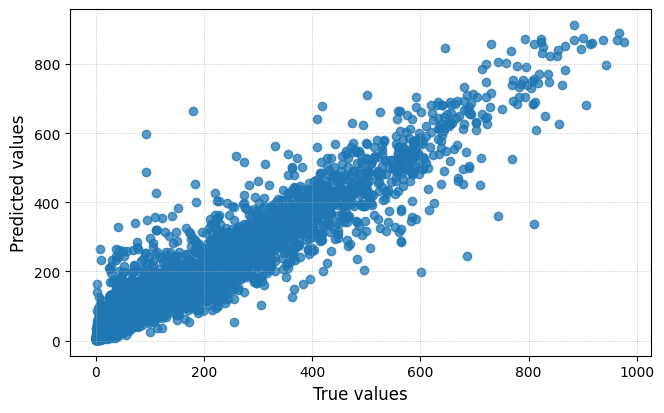

In [36]:
EvaluationFramework.plot_groundtruth_predictions(ytest, ypred)

### Test: Plain `sklearn` comparison

In [37]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)
r2 = r2_score(ytest, ypred)

print(f"\nRandom Forest R2 Score: {r2:.4f}")


Random Forest R2 Score: 0.9067


## Example: Beyond `sklearn`
We may want to use different models. The `mlght` framework supports any model that implements `fit` and `predict` methods.

Here we define a simple PyTorch model and train it via the `Trainer` interface.

### Define `torch` Dataset and Module

Note that the derived `nn.Module` is a PyTorch module which implements fit and predict methods. This makes the model fully compatible with the `Trainer` class.

In [38]:
from dataclasses import dataclass
import torch
from torch import nn

In [39]:
@dataclass
class Hyperparams:
    def __init__(
            self,
            epochs,
            batch_size,
            learning_rate,
            weight_decay
        ):
        self.epochs        = epochs
        self.batch_size    = batch_size
        self.learning_rate = learning_rate
        self.weight_decay  = weight_decay
    #end
#end

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X.to_numpy())
        self.y = torch.Tensor(y.to_numpy())
        self.features_names = X.columns
        self.label_name = y.columns
    #end
    
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])
    #end
    
    def __len__(self):
        return len(self.X)
    #end
#end

class NeuralNetwork(nn.Module):
    def __init__(
            self,
            layers,
            pbar_module,
            epochs,
            batch_size,
            learning_rate,
            weight_decay
        ):
        super(NeuralNetwork, self).__init__()

        # Model definition
        self.model = nn.Sequential(
            *self._make_layers(layers)
        )

        # Hyper-parameters
        self.hparams = Hyperparams(
            epochs        = epochs,
            batch_size    = batch_size, 
            learning_rate = learning_rate,
            weight_decay  = weight_decay 
        )

        self.pbar_module = pbar_module
    #end

    def _make_layers(self, layers):
        net_layers = []
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:
                net_layers.append(
                    nn.Linear(layers[i], layers[i+1])
                )
            else:
                net_layers.append(
                    nn.Linear(layers[i], layers[i+1])
                )
                net_layers.append(
                    nn.ReLU()
                )
        return net_layers
    
    def forward(self, data):
        output = self.model(data)
        return output

    def fit(self, X, y):
        train_loader = torch.utils.data.DataLoader(
            dataset = Dataset(X, y),
            batch_size = self.hparams.batch_size
        )
        
        opt = torch.optim.Adam(
            self.model.parameters(),
            lr = self.hparams.learning_rate,
            weight_decay = self.hparams.weight_decay
        )
        l2loss = nn.MSELoss(reduction = "mean")
        l1loss = nn.L1Loss(reduction = "mean")
        
        losses = []
        pbar_epochs = self.pbar_module(
            total = self.hparams.epochs,
            colour = "green",
            position = 2, leave = False
        )
        for epoch in range(self.hparams.epochs):
            pbar_epochs.set_description(f"Epoch: {epoch}")
            
            rloss = 0
            for x, y in train_loader:
                opt.zero_grad()
                y_ = self.forward(x)
                loss = 1.15 * l2loss(y_, y) + 0.75 * l1loss(y_, y)
                loss.backward()
                opt.step()
                rloss += loss.item() / x.shape[0]
            #end
            losses.append(rloss)
            
            pbar_epochs.update()
        #end
        
        self.losses = losses
        self.coef_ = [self.parameters()]
        self.intercept_ = None
    #end

    def predict(self, X):
        self.model.eval()
        ypred = self.model(torch.Tensor(X.to_numpy()))
        return ypred.detach().numpy()
    #end
#end

### Instantiate the trainer

In [40]:
base_estimator = NeuralNetwork
estimator_kwargs = dict(
    layers = [
        len(X.columns),
        32,
        16,
        8,
        len(y.columns)
    ],
    pbar_module = tqdm,
    epochs = 50,
    batch_size = 512,
    learning_rate = 0.001,
    weight_decay = 1e-5
)

trainer = Trainer(
    base_estimator = base_estimator,
    estimator_name = "MultiLayerPerceptron",
    estimator_kwargs = estimator_kwargs,
    n_cv_splits = 5,
    n_estimators = 10,
    eval_metrics = {
        "MAE": mean_absolute_error,
        "RMSE": root_mean_squared_error,
        "R2": r2_score
    },
    input_normalizer = ResettableStandardScaler,
    target_normalizer = ResettableStandardScaler,
    pbar_module = tqdm
)

### K-fold, model train and predict

In [41]:
trainer.run_kfold_cv(Xtrain, ytrain)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

+----------+------------------+
| Metric   | cnt              |
+==========+==================+
| MAE      | 23.6989 ± 1.4657 |
+----------+------------------+
| R2       | 0.9528 ± 0.0034  |
+----------+------------------+
| RMSE     | 39.4948 ± 1.5469 |
+----------+------------------+


In [42]:
trainer.fit(Xtrain, ytrain)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [43]:
ypred = trainer.predict(Xtest, columns = ytest.columns, index = ytest.index)
_ = trainer.evaluate(ytest, ypred, print_metrics = True)


------------
Evaluation: 

+------+-----------+
|      |       cnt |
+======+===========+
| MAE  | 24.423    |
+------+-----------+
| RMSE | 40.234    |
+------+-----------+
| R2   |  0.949996 |
+------+-----------+


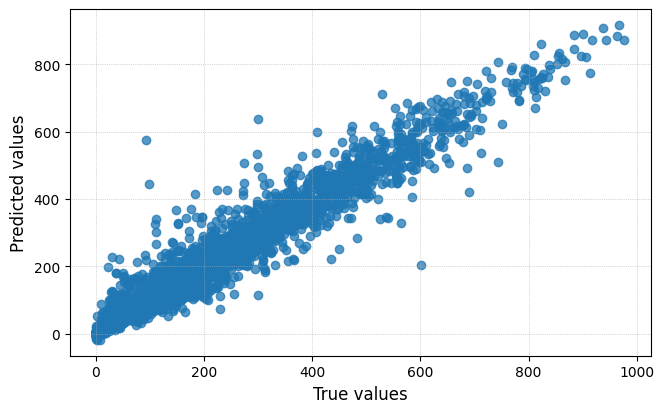

In [44]:
EvaluationFramework.plot_groundtruth_predictions(ytest, ypred)